In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

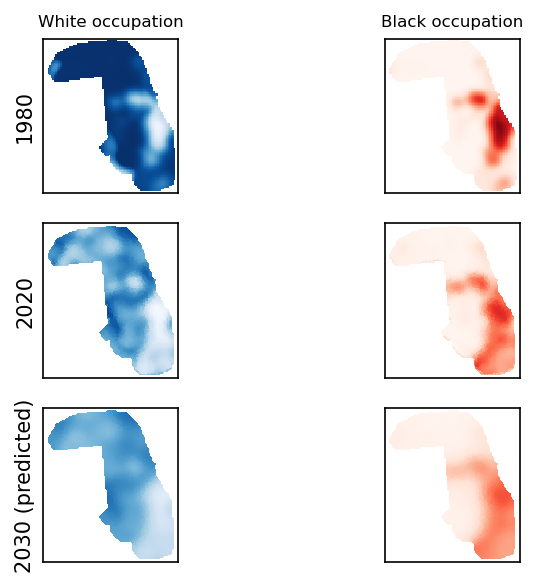

In [2]:
import dolfin_adjoint as d_ad
from data_processing import scalar_img_to_mesh
def plot_mesh(ax, f, mesh, lw=False, scale=1, vmin=0, vmax=1, **kwargs):
    x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
    tri = mesh.cells()
    if lw:
        kwargs['edgecolors'] = 'black'
        kwargs['linewidth'] = 0.05
    if not isinstance(f, np.ndarray):
        ax.tripcolor(x, y, f.compute_vertex_values() * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.tripcolor(x, y, f * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    ax.set(xticks=[], yticks=[])

from data_processing import CensusDataset
county = 'cook_IL'
dataset = CensusDataset(county)
dataset.validate()

fig, ax = plt.subplots(3, 2, dpi=150, sharey=True, sharex=True)

sample = dataset.get_time(1980)
ax[0,0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
ax[0,1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

sample = dataset[30]

#Generate fields on mesh
V = sample['FctSpace']
N = V.dim()
Dww = d_ad.Function(V)
Dwb = d_ad.Function(V)
Dbw = d_ad.Function(V)
Dbb = d_ad.Function(V)
w0 = d_ad.Function(V)
b0 = d_ad.Function(V)

Dww.vector()[:] = sample['control_arr'][:N]
Dwb.vector()[:] = sample['control_arr'][N:2*N]
Dbw.vector()[:] = sample['control_arr'][2*N:3*N]
Dbb.vector()[:] = sample['control_arr'][3*N:4*N]

GammaW = d_ad.Constant(sample['control_arr'][4*N], name='gammaW')
GammaB = d_ad.Constant(sample['control_arr'][4*N+1], name='gammaB')
dt = d_ad.Constant(sample['dt'], name='dt')
w0 = scalar_img_to_mesh(sample['wb0'][0], sample['x'], sample['y'], sample['FctSpace'])
b0 = scalar_img_to_mesh(sample['wb0'][1], sample['x'], sample['y'], sample['FctSpace'])
#w0.vector()[:] = sample['control_arr'][4*N+3:5*N+3]
#b0.vector()[:] = sample['control_arr'][5*N+3:6*N+3]

wb, _, _ = sample['pde_forward'](Dww, Dwb, Dbw, Dbb, GammaW, GammaB, 10, w0, b0, dataset.mesh)
w1, b1 = wb.split(True)

plot_mesh(ax[1,0], w0, dataset.mesh, cmap='Blues')
plot_mesh(ax[1,1], b0, dataset.mesh, cmap='Reds')

plot_mesh(ax[2,0], w1, dataset.mesh, cmap='Blues')
plot_mesh(ax[2,1], b1, dataset.mesh, cmap='Reds')

ax[0,0].set_title('White occupation', fontsize=8)
ax[0,1].set_title('Black occupation', fontsize=8)
ax[0,0].set_ylabel('1980')
ax[1,0].set_ylabel('2020')
ax[2,0].set_ylabel('2030 (predicted)')
for a in ax.flatten():
    a.set_aspect('equal')
    a.set(xticks=[], yticks=[])
plt.tight_layout()


Using vmax = 0.0499308
Using vmax = 0.05357


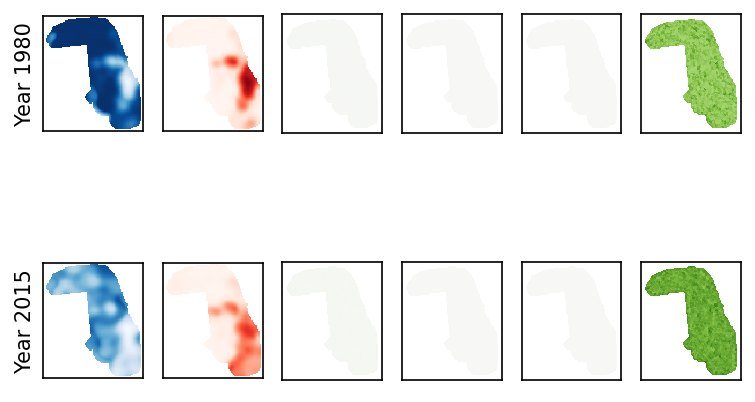

In [3]:
from pbnn import *

def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        Dij, Dij_mesh, gammas = model.forward(sample['wb0'][None],
                                              sample['FctSpace'],
                                              (sample['x'], sample['y']))
        Dij = Dij_mesh.reshape([4, -1])
        Dij = Dij.detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(4):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij
        
model = DiagonalOnlyPBNN().to(device)
info = torch.load('dynamic/DiagonalOnlyPBNN.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

fig, ax = plt.subplots(2, 6, dpi=150)
plot(ax[0], dataset[0], model)
plot(ax[1], dataset[35], model);

Using vmax = 0.397583


  0%|          | 0/40 [00:00<?, ?it/s]

Using vmax = 0.22382
Difference after 40 years is: 0.00890077


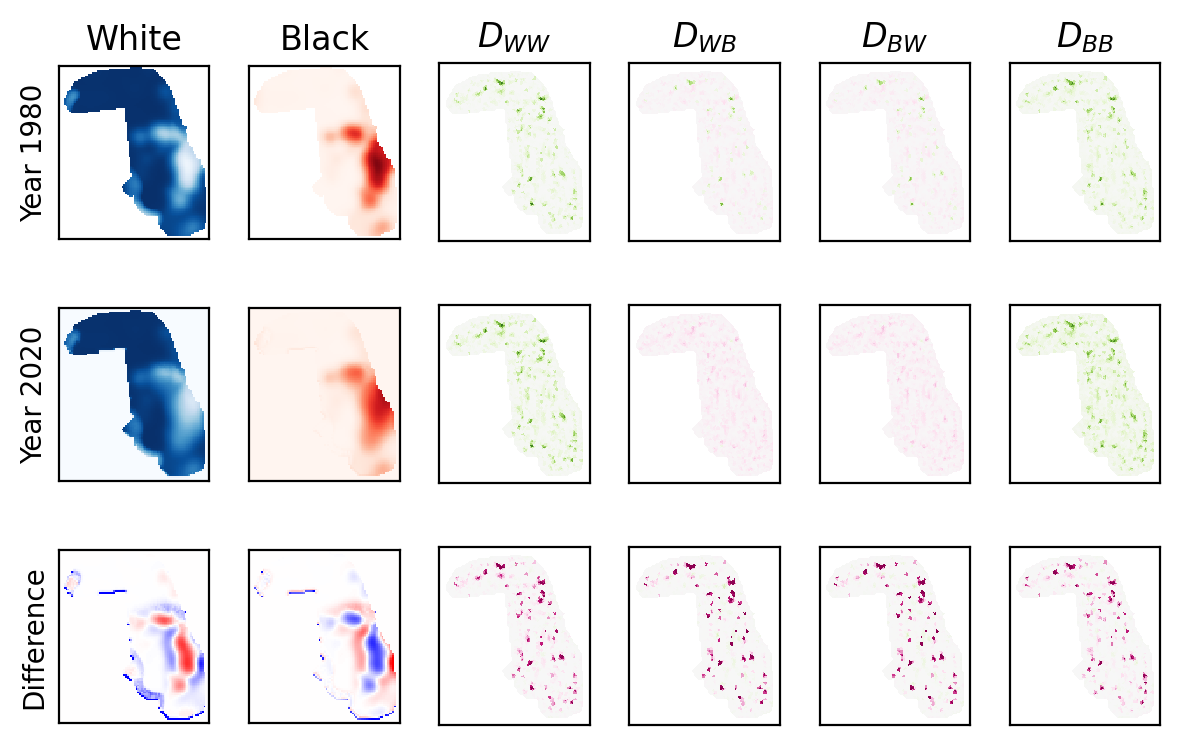

In [4]:
from pbnn import *
model = SymmetricCrossDiffusionPBNN().to(device)
info = torch.load('dynamic/SymmetricCrossDiffusionPBNN.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

fig, ax = plt.subplots(3, 6, dpi=200)
sample = dataset.get_time(t0, dt=dt)
sample['wb0'] = torch.FloatTensor(sample['wb0'])
wb0, Dij0 = plot(ax[0], sample, model)
mask = sample['mask']

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb1, Dij1 = plot(ax[1], sample, model)
print(f'Difference after {tmax} years is: {np.mean((wb0[:, mask]-wb1[:, mask])**2):g}')

diff = wb1 - wb0
vmax = 3*np.std(diff[:, mask])
ax[2, 0].pcolormesh(sample['x'], sample['y'], diff[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax[2, 1].pcolormesh(sample['x'], sample['y'], diff[1], cmap='bwr', vmin=-vmax, vmax=vmax)
diff = Dij1 - Dij0
vmax = 3*np.std(diff)
for i in range(4):
    plot_mesh(ax[2, 2+i], diff[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
for a in ax[2]:
    a.set(aspect='equal', xticks=[], yticks=[])
ax[2, 0].set_ylabel('Difference')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{WB}$')
ax[0,4].set_title('$D_{BW}$')
ax[0,5].set_title('$D_{BB}$')

plt.tight_layout()

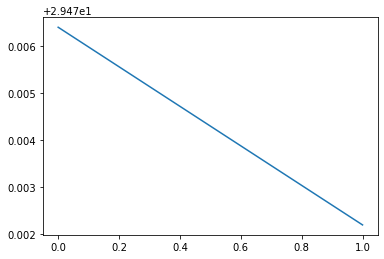

In [8]:
from pbnn import *
model = SymmetricCrossDiffusionPBNN().to(device)
info = torch.load('dynamic/SymmetricCrossDiffusionPBNN.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

plt.plot(info['val_loss'])